# User Input

In [1]:
# Directory to zonal_stats files run from `submit_zonal_stats.sh`
#directory_canada = "/home/khb47/ABoVE/scripts/zonal_stats/zonal_stats_Canada_*.txt"
directory_canada = "/home/khb47/ABoVE/scripts/zonal_stats/zonal_stats_Canada_*.txt"
directory_epa2 = "/home/khb47/ABoVE/scripts/zonal_stats/zonal_stats_EPA2_*.txt"""

# Stats one wants to visualize:
visualize = 'Canada' # Can be Canada or EPA2

# Code used to get correct ecoregions

# Set up
Import the libraries, load the shapefiles and create tables for the zonal statistics

In [2]:
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import glob
import os

In [3]:
# Load the shapefiles
epa_shapefile = "/projects/arctic/share/ABoVE_Biomass/OtherSpatialDatasets/EPA_ecoregion_lvl2_102001.shp"
canada_shapefile = "/projects/arctic/share/ABoVE_Biomass/OtherSpatialDatasets/CanadaAlaska_Boundaries_102001.shp"
epa_gdf = gpd.read_file(epa_shapefile)
canada_gdf = gpd.read_file(canada_shapefile)

ERROR 1: PROJ: proj_create_from_database: Open of /home/khb47/.conda/envs/ABoVE2024/share/proj failed


In [4]:
# Make the Canada zonal stats data
canada_alaska = pd.DataFrame()
for file in glob.glob(directory_canada):
    base_name = os.path.basename(file) 
    dataset_name = base_name[len("zonal_stats_Canada_"):-len(".txt")]
    dataset_canada_alaska = pd.read_csv(file, delimiter=', ', engine='python')
    dataset_canada_alaska['Dataset'] = dataset_name.split('_')[0]
    canada_alaska = pd.concat([canada_alaska, dataset_canada_alaska], ignore_index=True)
canada_alaska = canada_alaska.dropna(subset=['Mean'])
province_map = {
    'AB': 'Alberta',
    'BC': 'British Columbia',
    'MB': 'Manitoba',
    'NB': 'New Brunswick',
    'NL': 'Newfoundland and Labrador',
    'NS': 'Nova Scotia',
    'NT': 'Northwest Territories',
    'NU': 'Nunavut',
    'ON': 'Ontario',
    'PE': 'Prince Edward Island',
    'QC': 'Quebec',
    'SK': 'Saskatchewan',
    'YT': 'Yukon'
}
# Remove AB because it doesnt cover enough region?
#canada_alaska = canada_alaska[~canada_alaska['Zone'].isin(['AK'])]
canada_alaska['Zone'] = canada_alaska['Zone'].replace(province_map)
# Make Spawn Gibbs the right scale
canada_alaska.loc[canada_alaska['Dataset'] == 'SpawnGibbs2020', ['Mean', 'Median', 'Sum', 'Std']] /= 0.5
canada_alaska.loc[canada_alaska['Dataset'] == 'SpawnGibbs2020', ['Mean', 'Median', 'Sum', 'Std']] *= 0.1
canada_alaska.head()

,Zone,Mean,Median,Sum,Std,Coverage,Dataset
0,Manitoba,32.220672,23.0,1.917504e+10,33.197809,0.824652,Guindon2023
1,Saskatchewan,18.588853,6.0,1.176241e+10,23.261892,0.879153,Guindon2023
2,Alberta,63.751932,49.0,4.383320e+10,59.808092,0.936747,Guindon2023
3,British Columbia,92.639174,88.0,7.471263e+10,72.715217,0.771020,Guindon2023
5,Northwest Territories,16.519968,8.0,1.605488e+10,20.533091,0.651791,Guindon2023


In [5]:
# Make the Above EPA2 zonal stats data
epa2 = pd.DataFrame()
for file in glob.glob(directory_epa2):
    base_name = os.path.basename(file) 
    dataset_name = base_name[len("zonal_stats_EPA2_"):-len(".txt")]
    dataset_epa2 = pd.read_csv(file, delimiter=', ', engine='python')
    dataset_epa2['Dataset'] = dataset_name.split('_')[0]
    epa2 = pd.concat([epa2, dataset_epa2], ignore_index=True)
epa2 = epa2.dropna(subset=['Mean'])

epa2 = epa2[~epa2['Zone'].isin(['1.1  ARCTIC CORDILLERA', '2.1  NORTHERN ARCTIC', '2.2  ALASKA TUNDRA', '8.2  CENTRAL USA PLAINS', 
                               '2.3  BROOKS RANGE TUNDRA'])]
# For now, remove cold deserts and tiaga plane because coverage ares is 0.45
#epa2 = epa2[~epa2['Zone'].isin(['10.1  COLD DESERTS'])]
#epa2 = epa2[~((epa2['Zone'] == '3.3  TAIGA PLAIN') & (epa2['Dataset'] == 'Guindon2023'))]

# Make Spawn Gibbs the right scale
epa2.loc[epa2['Dataset'] == 'SpawnGibbs2020', ['Mean', 'Median', 'Sum', 'Std']] /= 0.5
epa2.loc[epa2['Dataset'] == 'SpawnGibbs2020', ['Mean', 'Median', 'Sum', 'Std']] *= 0.1
# Make Wang2020 on the right scale
epa2.loc[epa2['Dataset'] == 'Wang2020', ['Mean', 'Median', 'Sum', 'Std']] *= 0.01
epa2.head()

,Zone,Mean,Median,Sum,Std,Coverage,Dataset
7,3.1 ALASKA BOREAL INTERIOR,35.908367,34.14,1.073096e+10,26.959324,0.754256,Wang2020
8,3.2 TAIGA CORDILLERA,27.647849,24.49,5.598912e+09,24.209683,0.718984,Wang2020
9,3.3 TAIGA PLAIN,39.135437,38.32,1.854618e+10,28.891399,0.805017,Wang2020
15,5.4 BOREAL PLAIN,55.791841,52.86,1.625734e+10,37.011023,0.453383,Wang2020
16,6.1 BOREAL CORDILLERA,42.091436,41.29,2.179404e+10,33.032771,0.743419,Wang2020


In [ ]:
canada_alaska[canada_alaska[Dataset == ""]]

# Visualization of Zonal Stats
In the cell below you can change which type of file you are looking at, either Canada, or EPA2

In [16]:
# Change these depending on the region you want
visualize = 'EPA2'

if visualize == 'Canada':
    df = canada_alaska[canada_alaska['Coverage'] >= 0.50].copy()
    shapefile = canada_gdf.copy()
    key = 'postal'
elif visualize == 'EPA2':
    df = epa2[epa2['Coverage'] >= 0.50].copy()
    shapefile = epa_gdf.copy()
    key = 'NA_L2KEY'

## Bar chart of mean values across a dataset

In [105]:
df[df["Dataset"] == "Duncanson2025"]

,Zone,Mean,Median,Sum,Std,Coverage,Dataset


In [17]:
# Set a consistent order and color palette
# Need to put Duncanson back in
dataset_order = ['Duncanson2025','Guindon2023', 'Soto-Navarro2020', 'SpawnGibbs2020', 'Xu2021', 'Wang2020']
#dataset_order = ['Duncanson2025','Guindon2023', 'Soto-Navarro2020', 'SpawnGibbs2020', 'Xu2021']
# Originally had palette as tab10
palette = sns.color_palette('deep', n_colors=len(dataset_order))

df['Dataset'] = pd.Categorical(df['Dataset'], categories=dataset_order, ordered=True)

# Group by Zone and Dataset, then plot the mean values
grouped_mean = df.groupby(['Zone', 'Dataset'], observed=False)['Mean'].mean().unstack()

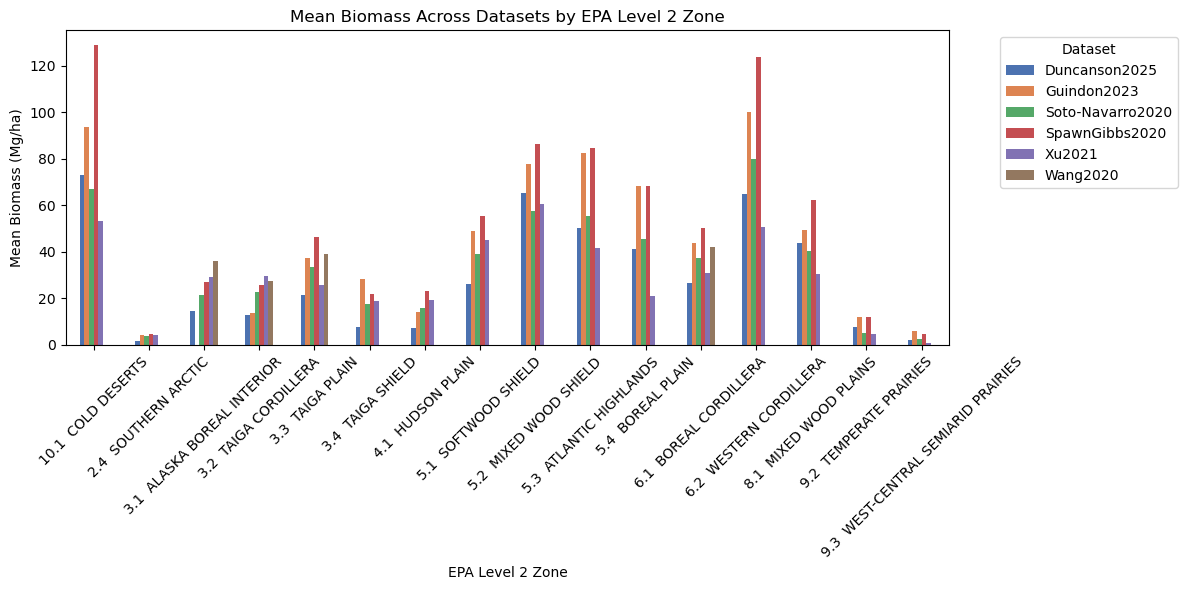

In [8]:
# Convert 'Mean' to numeric
df['Mean'] = pd.to_numeric(df['Mean'], errors='coerce')

# Group by Zone and Dataset, then plot the mean values
grouped_mean.plot(kind='bar', figsize=(12, 6), color=palette)
if visualize == 'Canada':
    plt.title('Mean Biomass Across Datasets by Canadian Province')
    plt.xlabel('Canadian Province')
else:
    plt.title('Mean Biomass Across Datasets by EPA Level 2 Zone')
    plt.xlabel('EPA Level 2 Zone')
plt.ylabel('Mean Biomass (Mg/ha)')
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Boxplot of Distribution by dataset

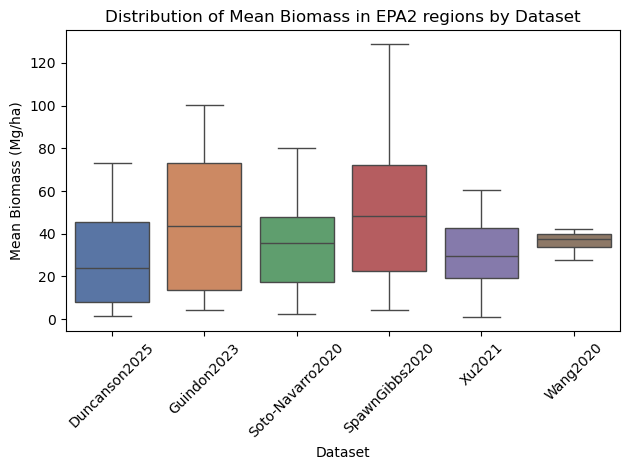

In [10]:
sns.boxplot(x='Dataset', y='Mean', data=df, order=dataset_order, palette=palette, hue='Dataset', legend=False)
if visualize == 'Canada':
    plt.title("Distribution of Mean Biomass in Canada by Dataset")
else:
    plt.title("Distribution of Mean Biomass in EPA2 regions by Dataset")
plt.ylabel("Mean Biomass (Mg/ha)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Choropleth Maps

/tmp/khb47/16203551/ipykernel_2742841/3080595617.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


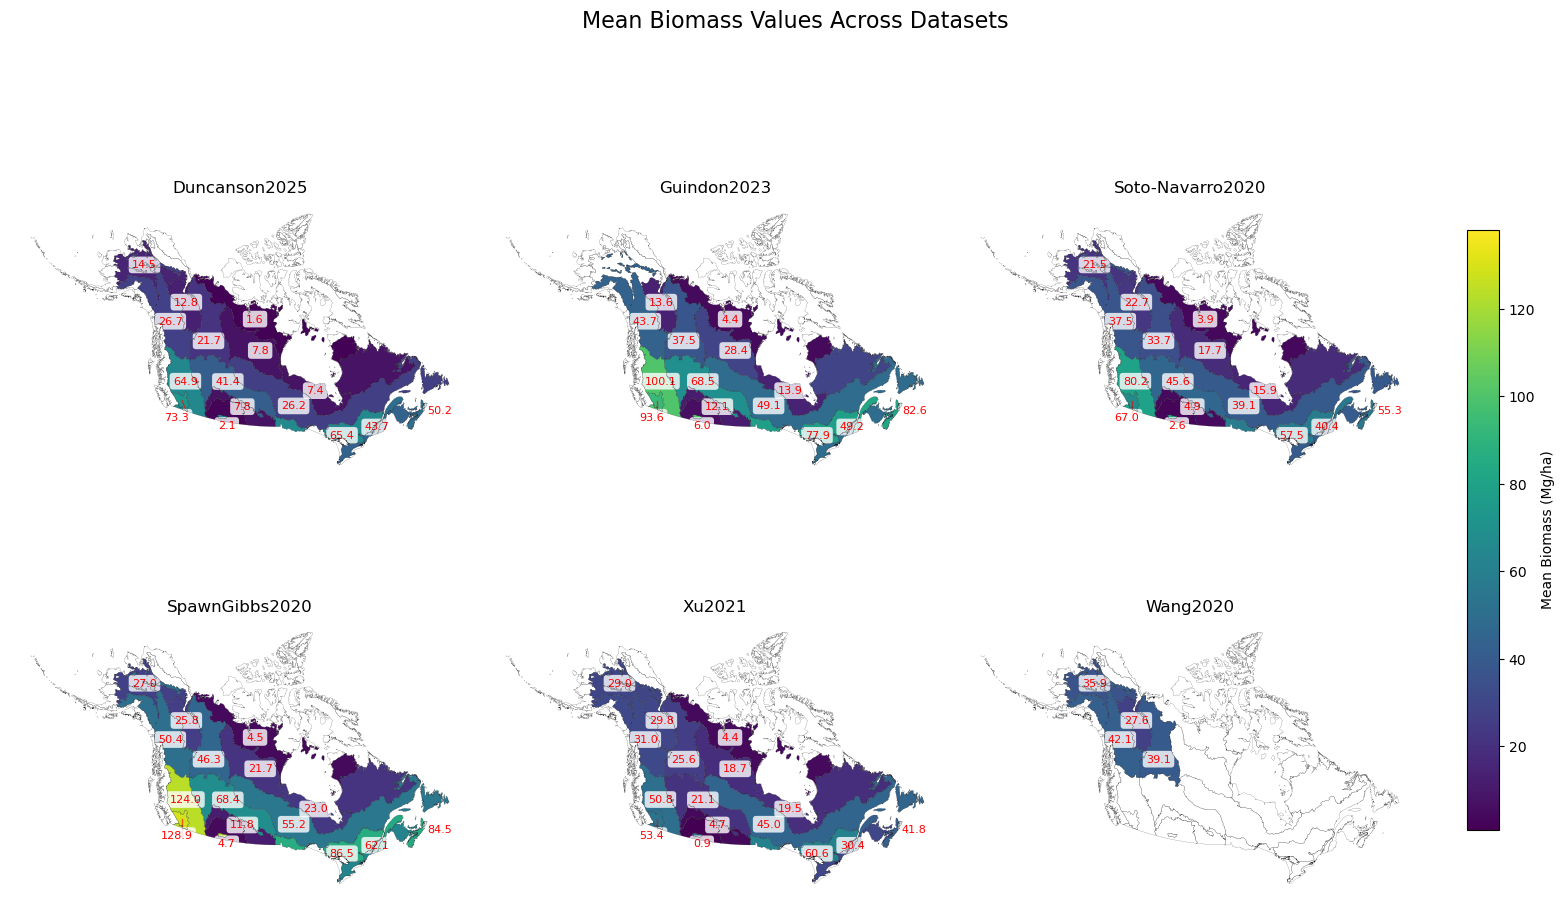

In [20]:
shapefile = epa_gdf
df_geo = shapefile.merge(df, left_on='NA_L2KEY', right_on='Zone')

# Assuming df_geo and shapefile are already defined
n_rows = 2
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 10))  # Increase figure size
axes = axes.flatten()

global_vmin = df_geo['Mean'].min()
global_vmax = df_geo['Mean'].max()

cmap = cm.viridis
norm = mcolors.Normalize(vmin=global_vmin, vmax=global_vmax)

offsets = {
    "10.1  COLD DESERTS": (-100000, -350000), # Need pointer
    "2.4  SOUTHERN ARCTIC": (-250000, 0),
    "3.3  TAIGA PLAIN": (0, -300000),
    "3.4  TAIGA SHIELD": (-1000000, 100000),
    "5.1  SOFTWOOD SHIELD": (-600000, -250000),
    "5.2  MIXED WOOD SHIELD": (0, -200000),
    "5.3  ATLANTIC HIGHLANDS": (700000, 0),
    "6.1  BOREAL CORDILLERA": (100000, -250000),
    "9.3  WEST-CENTRAL SEMIARID PRAIRIES": (0, -300000), # Needs pointer
}


for i, dataset in enumerate(dataset_order):
    df_subset = df_geo[df_geo['Dataset'] == dataset]
    
    # Plot without individual legends
    ax = df_subset.plot(
        column='Mean',
        cmap=cmap,
        ax=axes[i],
        vmin=global_vmin,
        vmax=global_vmax,
        legend=False  # Disable per-plot legend
    )
    
    shapefile.plot(
        ax=ax, 
        edgecolor='black',
        facecolor='none',
        linewidth=0.1,
        zorder=10
    )

    ax.set_title(f'{dataset}', fontsize=12)
    ax.set_axis_off()

    for x, y, mean, zone in zip(df_subset.geometry.centroid.x, 
                           df_subset.geometry.centroid.y, 
                           df_subset['Mean'].round(1),
                           df_subset['NA_L2KEY']
                               ):
        if not pd.isnull(mean):
            
            if zone in offsets:
                if zone in ['10.1  COLD DESERTS']:
                    ax.plot([x, x + dx], [y, y + dy], color="red", linewidth=1, alpha=0.6)
                dx, dy = offsets[zone]
                ax.annotate(
                    text=f'{mean}',
                    xy=(x + dx, y + dy),  # Adjusted position for visibility
                    ha='center', 
                    fontsize=8, 
                    color='red',
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.8)
                )
            else:
                ax.annotate(
                    text=f'{mean}', 
                    xy=(x, y), 
                    ha='center', 
                    fontsize=8, 
                    color='red',
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.8)
                )

# Add a single colorbar
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Position: [left, bottom, width, height]
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, cax=cbar_ax, label='Mean Biomass (Mg/ha)')

# Remove any empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

fig.suptitle('Mean Biomass Values Across Datasets', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 0.9, 1])

plt.show()

/tmp/khb47/16203551/ipykernel_2742841/2349430125.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


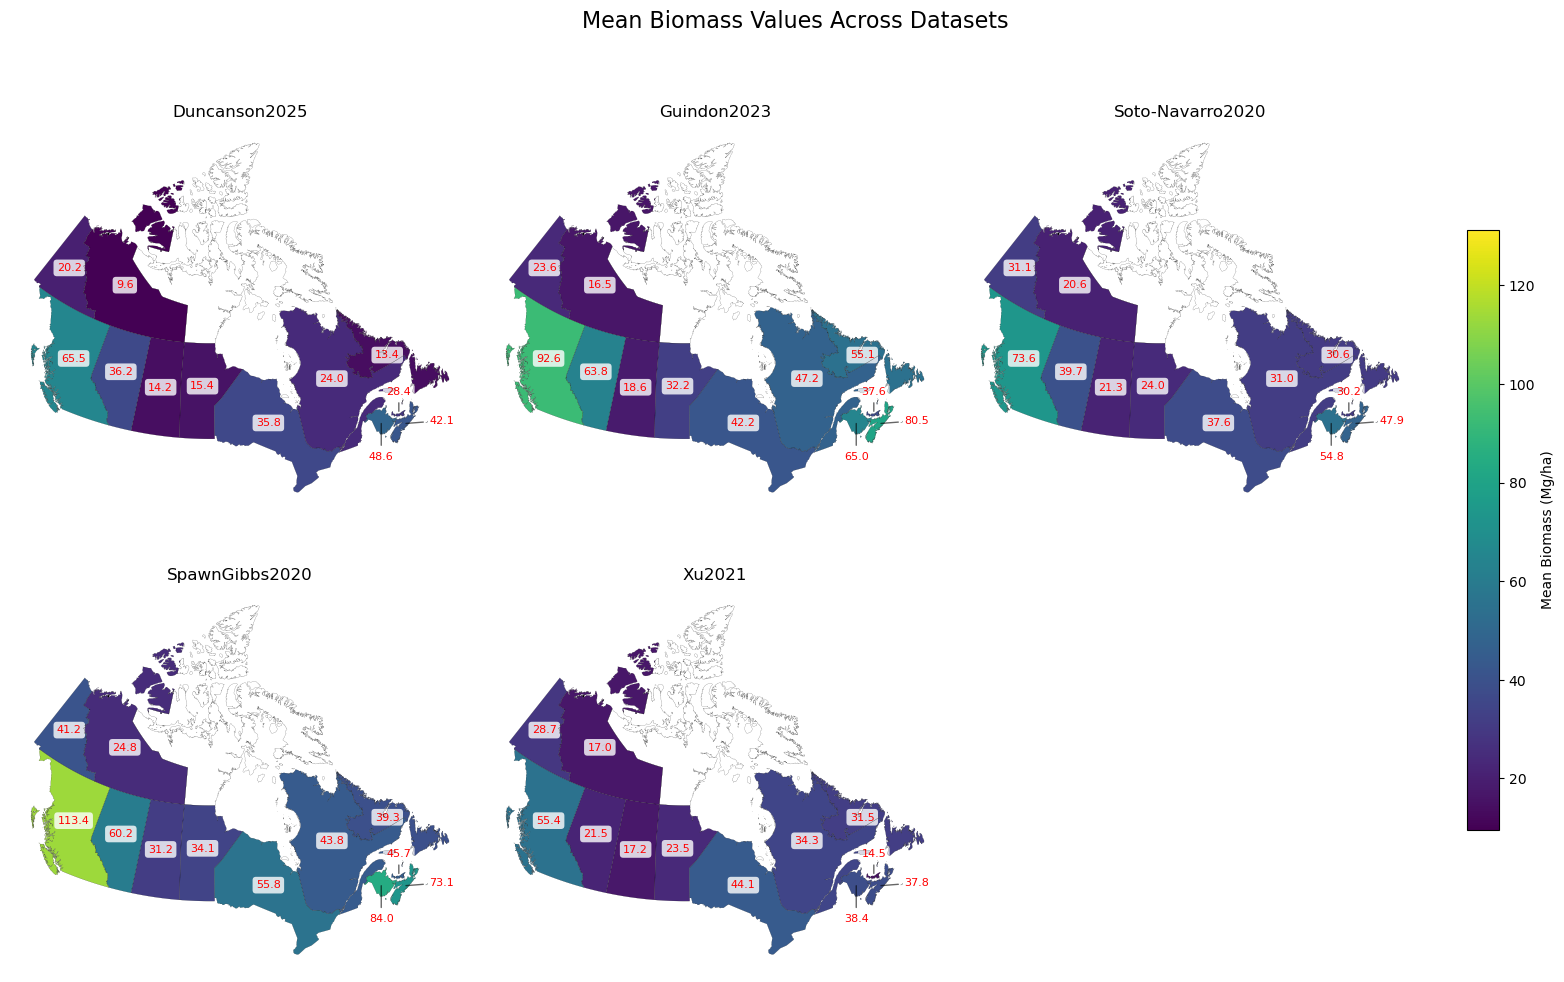

In [15]:
if visualize == "Canada":
    shapefile = canada_gdf[canada_gdf['postal'] != 'AK']  # Exclude Alaska
    shapefile.loc[:, 'postal'] = shapefile['postal'].replace(province_map)
    df_geo = shapefile.merge(df, left_on='postal', right_on='Zone')
    # Define offsets for NB, PE, and NS to move the text and error bars
    offsets = {
        "New Brunswick": (0, -500000),
        "Prince Edward Island": (0, 250000),
        "Nova Scotia": (500000, 0),
        "Northwest Territories": (-100000, -100000)
    }
else:
    shapefile = epa_gdf
    df_geo = shapefile.merge(df, left_on='NA_L2KEY', right_on='Zone')

n_rows = 2
n_cols = 3

# Merge DataFrame with GeoDataFrame
df_geo[['Mean', 'Median', 'Sum', 'Std']] = df_geo[['Mean', 'Median', 'Sum', 'Std']].round(2)

# Create a grid of plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 10))
axes = axes.flatten()

global_vmin = df_geo['Mean'].min()
global_vmax = df_geo['Mean'].max()

# Create a colormap and normalization for the colorbar
cmap = cm.viridis
norm = mcolors.Normalize(vmin=global_vmin, vmax=global_vmax)

for i, dataset in enumerate(dataset_order):
    df_subset = df_geo[df_geo['Dataset'] == dataset]
    
    # Plot without individual legends
    ax = df_subset.plot(
        column='Mean',
        cmap=cmap,
        ax=axes[i],
        vmin=global_vmin,
        vmax=global_vmax,
        legend=False  # Disable per-plot legend
    )
    
    shapefile.plot(
        ax=ax, 
        edgecolor='black',
        facecolor='none',
        linewidth=0.1,
        zorder=10
    )

    ax.set_title(f'{dataset}', fontsize=12)
    ax.set_axis_off()

    for x, y, mean, zone in zip(df_subset.geometry.centroid.x, 
                           df_subset.geometry.centroid.y, 
                           df_subset['Mean'].round(1),
                           df_subset['Name_EN']
                               ):
        if not pd.isnull(mean):

            dx, dy = offsets.get(zone, (0, 0))  # Default offset (0,0) if not in offsets dictionary

            ax.annotate(
                text=f'{mean}',
                xy=(x, y),
                xytext=(x + dx, y + dy),  # Adjusted position
                ha='center', 
                fontsize=8, 
                color='red',
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.8),
                arrowprops=dict(arrowstyle="-", color="black", alpha=0.6) if dx or dy else None
            )

# Add a single colorbar
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Position: [left, bottom, width, height]
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, cax=cbar_ax, label='Mean Biomass (Mg/ha)')

# Remove any empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

fig.suptitle('Mean Biomass Values Across Datasets', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 0.9, 1])

plt.show()

## Summary Table using a Heatmap

/tmp/khb47/16147265/ipykernel_2958929/4124258913.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_table = df.groupby(['Zone', 'Dataset']).agg(


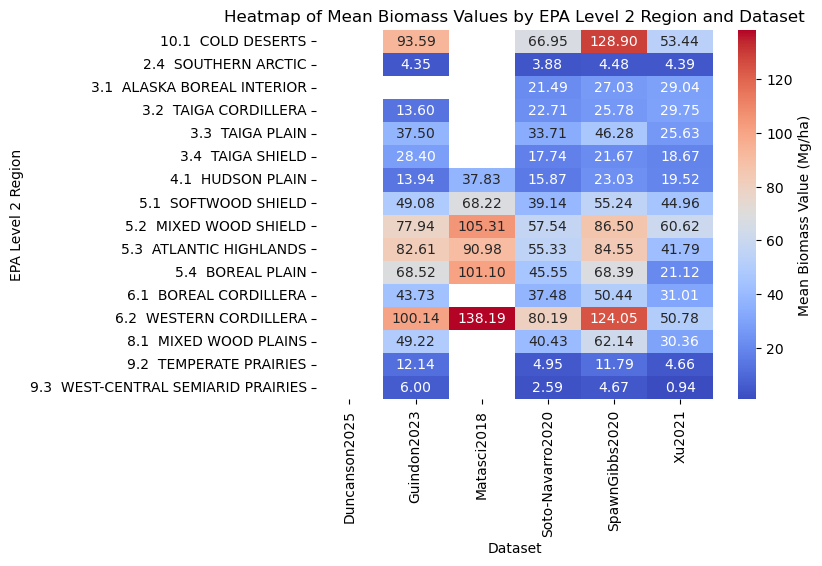

In [13]:
summary_table = df.groupby(['Zone', 'Dataset']).agg(
    Mean=('Mean', 'mean'),
    Median=('Median', 'mean'),
    Sum=('Sum', 'sum'),
    Std=('Std', 'mean')
)

# Visualize using a heatmap
summary_pivot = summary_table.reset_index().pivot(index='Zone', columns='Dataset', values='Mean')
sns.heatmap(summary_pivot, cmap='coolwarm', annot=True, fmt=".2f", cbar_kws={'label': 'Mean Biomass Value (Mg/ha)'})
if visualize == 'Canada':
    plt.title('Heatmap of Mean Biomass Values by Province and Dataset')
    plt.ylabel('Province')
else:
    plt.title('Heatmap of Mean Biomass Values by EPA Level 2 Region and Dataset')
    plt.ylabel('EPA Level 2 Region')
plt.show()
